In [ ]:
!pip install scikit-optimize
!pip install seaborn

In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 设置GPU设备，如果没有可用的GPU，则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(888888)

print(device)

cpu


In [3]:
# 基础参数
h = 100    # 画图网格密度
N = 1000    # 内点配置点数
N1 = 0.01    # 边界点配置点数
N2 = 1000    # PDE数据点

In [4]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
# 定义模型并加载权重
u = MLP().to(device)
u.load_state_dict(torch.load('weights_4D.pth', map_location=device))
u.eval()  # 设置模型为评估模式

# 定义第n象限的网格点
h = 500  # 网格的点数，调整以改变分辨率
xc = torch.linspace(-1, 1, h, device=device)
yc = torch.linspace(-1, 1, h, device=device)
xm, ym = torch.meshgrid(xc, yc)
xx = xm.reshape(-1, 1)
yy = ym.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1).to(device)

# 使用模型对网格点进行预测
with torch.no_grad():  # 禁用梯度计算，以提高预测速度
    predictions = torch.relu(u(xy))

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


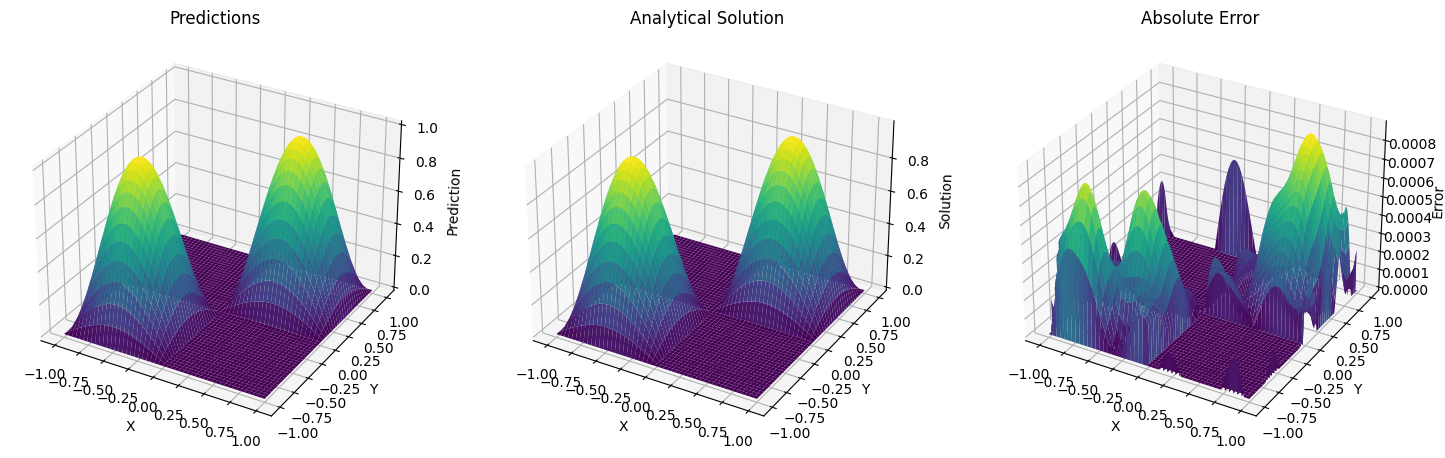

In [6]:
# 计算解析解
analytical_solution = torch.relu(torch.sin(torch.pi * xx) * torch.sin(torch.pi * yy)).to(device)

# 计算绝对误差
absolute_error = torch.abs(predictions - analytical_solution)

# 将预测值、解析解和绝对误差重新整形为网格形状
predictions = predictions.cpu().numpy().reshape(h, h)
analytical_solution = analytical_solution.cpu().numpy().reshape(h, h)
absolute_error = absolute_error.cpu().numpy().reshape(h, h)

# 绘制预测值的3D图形
fig = plt.figure(figsize=(18, 6))

# 预测值图像
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(xm.cpu().numpy(), ym.cpu().numpy(), predictions, cmap='viridis')
ax1.set_title('Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Prediction')

# 解析解图像
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(xm.cpu().numpy(), ym.cpu().numpy(), analytical_solution, cmap='viridis')
ax2.set_title('Analytical Solution')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Solution')

# 绝对误差图像
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(xm.cpu().numpy(), ym.cpu().numpy(), absolute_error, cmap='viridis')
ax3.set_title('Absolute Error')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Error')

plt.show()

<Figure size 1800x600 with 0 Axes>

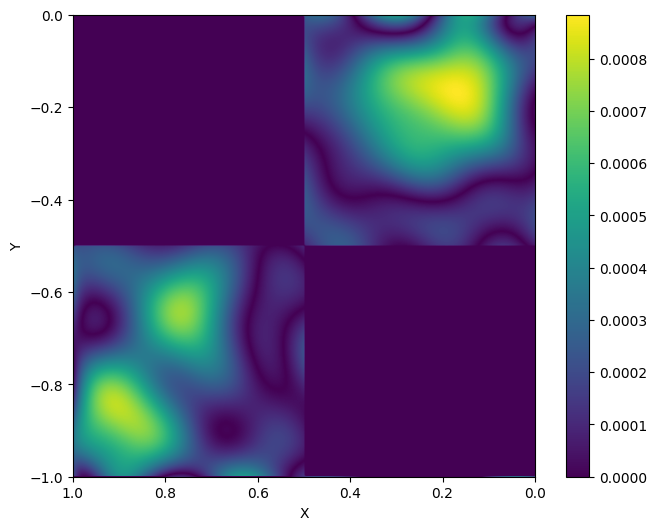

In [7]:
# 绝对误差图像
fig = plt.figure(figsize=(18, 6))
ax3 = fig.add_subplot(131, projection='3d')
ax3.plot_surface(xm.cpu().numpy(), ym.cpu().numpy(), absolute_error, cmap='viridis')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Error')

# 保存绝对误差图像
fig.savefig('absolute_error_4domain_3d.png', dpi=300)
plt.clf()  # 清除当前图像以便下次绘制

plt.show()


# 绘制2D误差图
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.imshow(absolute_error, extent=[1, 0, -1, 0], origin='lower', cmap='viridis')
fig.colorbar(c, ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 保存2D误差图像
fig.savefig('absolute_error_4domain_2d.png', dpi=300)
plt.show()

## 能满足右边的

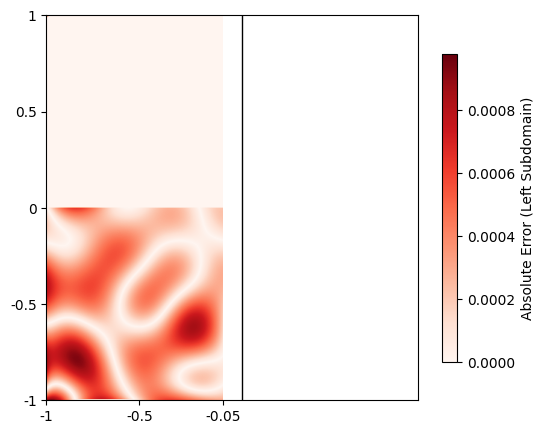

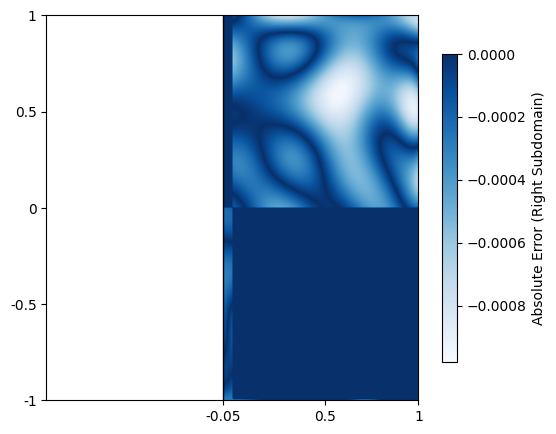

In [27]:
# 使用模型对网格点进行预测
with torch.no_grad():
    predictions = torch.relu(u(xy))  # 仍是 PyTorch Tensor

# 计算解析解
analytical_solution = torch.relu(torch.sin(torch.pi * xx) * torch.sin(torch.pi * yy)).to(device)

# 计算误差
absolute_error_tensor = torch.abs(predictions - analytical_solution)

# 转换为 NumPy 数组以便绘图
error_array = absolute_error_tensor.cpu().numpy().reshape(h, h)

# **以 x = -0.05 为界**，确保左侧为正误差，右侧为负误差
xcoords = xc.cpu().numpy()  # 获取 x 坐标
col_idx = np.where(xcoords >= -0.05)[0]  # 取 x >= -0.05 的索引

# **修改误差数据 (左: 正, 右: 负)**
error_array[:, col_idx] *= -1  # 让左右颜色相反

# **找到最大误差值**
max_error = np.max(np.abs(error_array))

### **第一张图：(-1, 0.05) 左侧区域 (红色)**
fig, ax = plt.subplots(figsize=(6, 5))

# 仅绘制 (-1, 0.05) 的区域，右侧区域填充灰色
masked_error_left = np.full_like(error_array, np.nan)  # 初始化为 NaN
masked_error_left[:, :col_idx[0]] = error_array[:, :col_idx[0]]  # 左侧区域保留数据

im = ax.imshow(
    masked_error_left,
    extent=[-1, 1, -1, 1],
    origin='lower',
    cmap='Reds',  # 只用红色
    aspect='auto',
    norm=Normalize(vmin=0, vmax=max_error)  # 只显示正误差
)

ax.axvline(0.05, color='k', linestyle='-', linewidth=1.0)  # 分界线

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Absolute Error (Left Subdomain)")

ax.set_xticks([-1, -0.5, -0.05])
ax.set_xticklabels(['-1', '-0.5', '-0.05'])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])

plt.savefig("left_subdomain_absolute_error.png", dpi=300)
plt.show()


### **第二张图：(-0.05, 1) 右侧区域 (蓝色)**
fig, ax = plt.subplots(figsize=(6, 5))

# 仅绘制 (-0.05, 1) 的区域，左侧区域填充灰色
masked_error_right = np.full_like(error_array, np.nan)  # 初始化为 NaN
masked_error_right[:, col_idx[0]:] = error_array[:, col_idx[0]:]  # 右侧区域保留数据

im = ax.imshow(
    masked_error_right,
    extent=[-1, 1, -1, 1],
    origin='lower',
    cmap='Blues',  # 只用蓝色
    aspect='auto',
    norm=Normalize(vmin=-max_error, vmax=0)  # 只显示负误差
)

ax.axvline(-0.05, color='k', linestyle='-', linewidth=1.0)  # 分界线

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Absolute Error (Right Subdomain)")

ax.set_xticks([-0.05, 0.5, 1])
ax.set_xticklabels(['-0.05', '0.5', '1'])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])

plt.savefig("right_subdomain_absolute_error.png", dpi=300)
plt.show()


## 能满足左边的

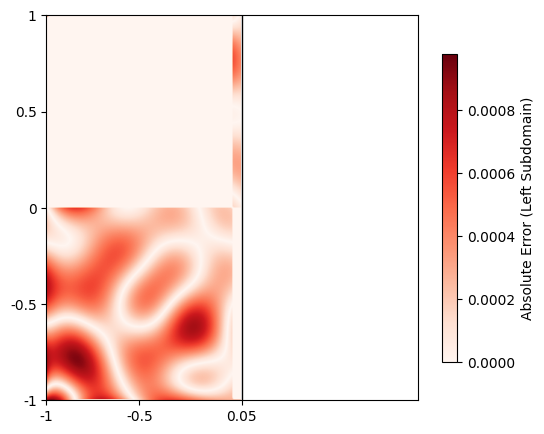

In [30]:
# 使用模型对网格点进行预测
with torch.no_grad():
    predictions = torch.relu(u(xy))  # 仍是 PyTorch Tensor

# 计算解析解
analytical_solution = torch.relu(torch.sin(torch.pi * xx) * torch.sin(torch.pi * yy)).to(device)

# 计算误差
absolute_error_tensor = torch.abs(predictions - analytical_solution)

# 转换为 NumPy 数组以便绘图
error_array = absolute_error_tensor.cpu().numpy().reshape(h, h)

# **以 x = 0.05 为界**，确保左侧为正误差，右侧为负误差
xcoords = xc.cpu().numpy()  # 获取 x 坐标
col_idx = np.where(xcoords >= 0.05)[0]  # 取 x >= 0.05 的索引

# **修改误差数据 (左: 正, 右: 负)**
error_array[:, col_idx] *= -1  # 让左右颜色相反

# **找到最大误差值**
max_error = np.max(np.abs(error_array))

### **第一张图：(-1, 0.05] 左侧区域 (红色)**
fig, ax = plt.subplots(figsize=(6, 5))

# 仅绘制 (-1, 0.05] 的区域，右侧区域填充灰色
masked_error_left = np.full_like(error_array, np.nan)  # 初始化为 NaN
masked_error_left[:, :col_idx[0]] = error_array[:, :col_idx[0]]  # 左侧区域保留数据

im = ax.imshow(
    masked_error_left,
    extent=[-1, 1, -1, 1],
    origin='lower',
    cmap='Reds',  # 只用红色
    aspect='auto',
    norm=Normalize(vmin=0, vmax=max_error)  # 只显示正误差
)

ax.axvline(0.05, color='k', linestyle='-', linewidth=1.0)  # 分界线

cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Absolute Error (Left Subdomain)")

ax.set_xticks([-1, -0.5, 0.05])
ax.set_xticklabels(['-1', '-0.5', '0.05'])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])

plt.savefig("left_subdomain_absolute_error_fixed.png", dpi=300)
plt.show()
